In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from scipy.stats import beta
from scipy.special import betaln
from functools import partial
from repeats_utils import *
from plotting_utils import spring_layout
from math import log
from plotting_utils import figure_path
#import adjustText
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
count_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,0,0,0,0,1164939,69311,...,0,0,0,0,0,0,26647609,26664118,26647609,26664118
1,.,.,tRNA,tRNA,0,0,0,0,10237961,0,...,0,0,0,0,0,0,568,0,568,0
2,.,No features:.,Repeats,Repeats,3745,4542,2989,3742,35812,17223,...,94446,92684,159513,155574,101781,100419,16867723,16876133,16867723,16876133
3,18S_rRNA,18S_rRNA,rDNA,rRNA,0,0,0,0,734,175520,...,0,0,0,0,0,0,225,252,225,252
4,28S_rRNA,28S_rRNA,rDNA,rRNA,0,0,0,0,1089,384807,...,0,0,0,0,0,0,506,533,506,533


(3.0400600236661712, 3.0342780746836864, 0, 1)


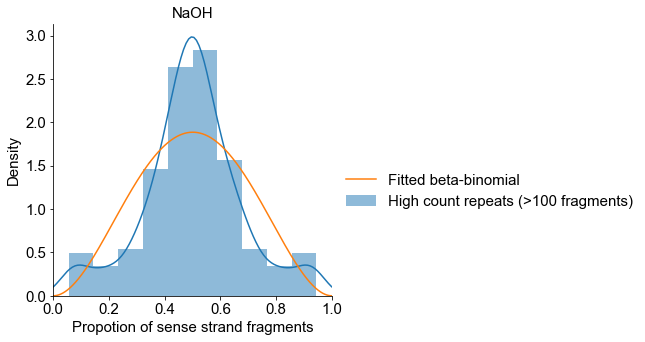

In [7]:
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
#sample_regex = '[aA][lL][lL]'
p_df = get_repeat_df(df, sample_regex = sample_regex)


ax = fig.add_subplot(111)
sample_regex = 'Q[cC][fF]_[Nn][aA]'
naoh_p_df = get_repeat_df(df, sample_regex = sample_regex)
naoh_alpha0, naoh_beta0 = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15, frameon=False)

Text(22.125, 0.5, 'Posterior sense strand proportion')

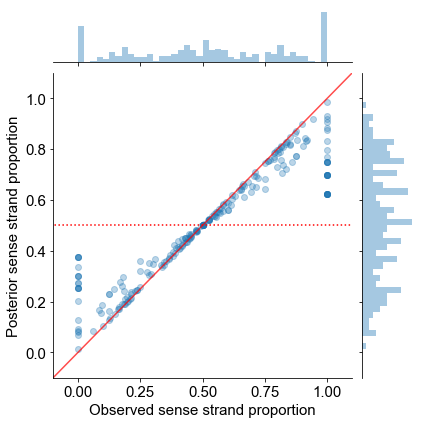

In [11]:
dnase_posterior_df = update_empirical_bayesr(p_df, naoh_alpha0, naoh_beta0)
naoh_posterior_df = update_empirical_bayesr(naoh_p_df, naoh_alpha0, naoh_beta0)

p = sns.JointGrid(data = dnase_posterior_df,  x= 'average',y='eb_estimate')
p.plot_joint(plt.scatter, alpha=0.3)
p.plot_marginals(sns.distplot, kde=False, bins=40)
ax = p.ax_joint
ax.hlines(xmin=-10,xmax=10, 
          y=naoh_alpha0/(naoh_alpha0+naoh_beta0), color='r', linestyle=':')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
ax.plot(lims, lims, 'r-', alpha=.7)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Observed sense strand proportion')
ax.set_ylabel('Posterior sense strand proportion')
#sns.despine()

In [12]:
dnase_posterior_df.head()

,antisense,gene_id,gene_name,sense,average,eb_estimate,alpha1,beta1
768,5958,Satellite,Satellite:(CATTC)n,4151,0.410624,0.410678,4154.04006,5961.034278
769,2343,Satellite,Satellite:(GAATG)n,5729,0.709737,0.709580,5732.04006,2346.034278
770,517,Satellite,Satellite:BSR/Beta,399,0.435590,0.436017,402.04006,520.034278
771,139,Satellite,Satellite:CER,88,0.387665,0.390605,91.04006,142.034278
772,17,Satellite,Satellite:D20S16,11,0.392857,0.412042,14.04006,20.034278


In [31]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['gene_name', 'gene_id'],
         columns = 'variable', values = 'value') \
    .pipe(lambda d: fill_prior(d, (naoh_alpha0, naoh_beta0)))\
    .reset_index() \
    .fillna(0)\
    .pipe(lambda d: calulate_probability(d))  \
    .assign(delta_sense = lambda d: d['DNase: eb_estimate'] - d['NaOH: eb_estimate'])
posterior_df.sort_values('log_bf', ascending=False).head(20)
posterior_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense
1,Satellite:(GAATG)n,Satellite,5732.04006,2343.0,0.709737,2346.034278,0.709580,5729.0,44014.04006,67827.0,0.393525,67830.034278,0.393530,44011.0,6401.488099,0.000000e+00,0.000000e+00,0.316050
217,Simple_repeats:(GAAA)n,Simple_repeats,1352.04006,922.0,0.594011,925.034278,0.593762,1349.0,3637.04006,16565.0,0.179910,16568.034278,0.180006,3634.0,2370.277531,0.000000e+00,0.000000e+00,0.413756
216,Simple_repeats:(GAA)n,Simple_repeats,956.04006,682.0,0.582875,685.034278,0.582570,953.0,718.04006,7778.0,0.084187,7781.034278,0.084485,715.0,2076.129192,0.000000e+00,0.000000e+00,0.498085
230,Simple_repeats:(GGA)n,Simple_repeats,478.04006,773.0,0.380609,776.034278,0.381190,475.0,598.04006,7887.0,0.070149,7890.034278,0.070457,595.0,1215.383375,7.439331e-216,7.439331e-216,0.310733
173,Simple_repeats:(CGG)n,Simple_repeats,826.04006,143.0,0.851967,146.034278,0.849770,823.0,964.04006,1540.0,0.384246,1543.034278,0.384528,961.0,735.766233,9.210468e-198,9.210468e-198,0.465243


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


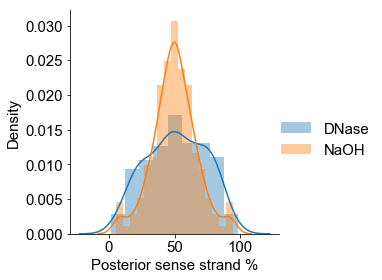

In [32]:
p = sns.FacetGrid(data =pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
                            naoh_posterior_df.assign(treatment='NaOH')])\
                      .assign(eb_estimate = lambda d: d.eb_estimate * 100), 
              hue = 'treatment',
              size = 4)
p.map(sns.distplot, 'eb_estimate')
p.set_axis_labels('Posterior sense strand %',
                'Density')
p.add_legend(title='', fontsize=15)

In [64]:
#https://repository.upenn.edu/cgi/viewcontent.cgi?article=3272&context=edissertations
telo = 'TAACCC|CCCGAA|CCCCAA|CCCTAG|TTAGGC|TTAGGG'
telo += '|' + reverse_complement(telo)
x_val = 'delta_sense'
y_val = 'log_bf'
plot_bf_df = posterior_df\
    .query('log_bf  > 0') \
    .assign(label = lambda d: np.where(d[x_val] < 0, 'Antisense','Sense')) \
    .assign(color = lambda d: 'gray')\
    .assign(color = lambda d: np.where(d.log_bf > 500, 'red', 
                                       np.where(d.log_bf > 2, 'darkred', d.color)))\
    .sort_values('log_bf', ascending=False)
plot_bf_df.head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense,label,color
3,Satellite:ALR/Alpha,centr,6011.04006,5431.0,0.525221,5434.034278,0.525208,6008.0,1.096844e+06,921764.0,0.543366,921767.034278,0.543366,1096841.0,7921.887251,0.999951,131.825933,-0.018158,Antisense,red
0,Satellite:(CATTC)n,Satellite,4154.04006,5958.0,0.410624,5961.034278,0.410678,4151.0,1.928200e+05,116072.0,0.624227,116075.034278,0.624225,192817.0,7756.553869,1.000000,161.825893,-0.213547,Antisense,red
1,Satellite:(GAATG)n,Satellite,5732.04006,2343.0,0.709737,2346.034278,0.709580,5729.0,4.401404e+04,67827.0,0.393525,67830.034278,0.393530,44011.0,6401.488099,0.000000,0.000000,0.316050,Sense,red
14,Satellite:HSATII,Satellite,2540.04006,2186.0,0.537159,2189.034278,0.537111,2537.0,4.512930e+05,283025.0,0.614573,283028.034278,0.614572,451290.0,3318.841378,1.000000,148.825893,-0.077460,Antisense,red
322,Simple_repeats:(TTTC)n,Simple_repeats,925.04006,1349.0,0.405989,1352.034278,0.406241,922.0,1.656804e+04,3634.0,0.820090,3637.034278,0.819994,16565.0,2370.279042,1.000000,147.825893,-0.413753,Antisense,red


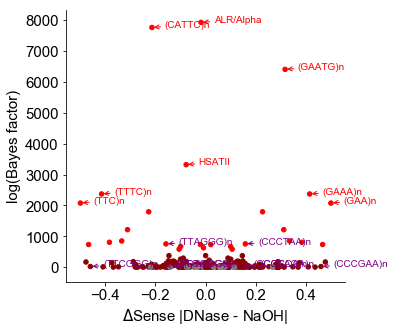

In [69]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
for lab, lab_df in  plot_bf_df.groupby('label'):
    alpha = 0.8
    color = 'gray' 
        
    data = []
    text = []
    colors = []
    for i, row in lab_df.iterrows():
        x = row[x_val]
        y = row[y_val]
        if (row[y_val] > 2000 or (row[y_val] > 0 and re.search(telo, row['gene_name']))): 
            color = row['color'] if not re.search(telo, row['gene_name']) else 'purple'
            text.append(row['gene_name'])
                
            ax.annotate(row['gene_name'].split(':')[1],
                    xy=(x, y), 
                    xycoords='data',
                    xytext=(x+0.05, y+1), 
                    textcoords='data',
                    color = color,
                    arrowprops=dict(arrowstyle="->",
                            color = color,
                            connectionstyle="arc3"))
    
    lab_df.plot.scatter(x_val, y_val, ax = ax, color = lab_df.color.tolist())#, alpha=alpha )
plt.axvline(x = 0, linestyle=':', alpha=0.01, color='gray')
sns.despine()
#ax.set_ylim(0,1000)
ax.set_ylabel('log(Bayes factor)')
ax.set_xlabel('$\Delta$Sense |DNase - NaOH|')
fig.savefig(figure_path + '/bayes_factor_satellite.png',bbox_inches ='tight')

In [66]:
plot_bf_df[plot_bf_df.gene_name.str.contains(telo+'|telo')]

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense,label,color
301,Simple_repeats:(TTAGGG)n,Simple_repeats,198.04006,1725.0,0.101562,1728.034278,0.102821,195.0,1865.04006,5287.0,0.260456,5290.034278,0.260660,1862.0,755.720320,1.000000e+00,1.528259e+02,-0.157839,Antisense,red
144,Simple_repeats:(CCCTAA)n,Simple_repeats,1728.04006,195.0,0.898438,198.034278,0.897182,1725.0,5290.04006,1862.0,0.739544,1865.034278,0.739341,5287.0,755.719263,1.072333e-67,1.072333e-67,0.157841,Sense,red
317,Simple_repeats:(TTGGGG)n,Simple_repeats,19.04006,26.0,0.380952,29.034278,0.396055,16.0,322.04006,248.0,0.562610,251.034278,0.561952,319.0,30.530229,9.897245e-01,1.128625e+02,-0.165897,Antisense,darkred
133,Simple_repeats:(CCCCAA)n,Simple_repeats,29.04006,16.0,0.619048,19.034278,0.604066,26.0,251.04006,319.0,0.437390,322.034278,0.438058,248.0,30.529939,1.023317e-02,6.242414e-02,0.166007,Sense,darkred
311,Simple_repeats:(TTCGGG)n,Simple_repeats,3.04006,38.0,0.000000,41.034278,0.068976,0.0,67.04006,57.0,0.528926,60.034278,0.527566,64.0,23.720520,1.000000e+00,1.418259e+02,-0.458590,Antisense,darkred
141,Simple_repeats:(CCCGAA)n,Simple_repeats,41.04006,0.0,1.000000,3.034278,0.931155,38.0,60.04006,64.0,0.471074,67.034278,0.472480,57.0,23.717666,1.228269e-11,1.695780e-11,0.458676,Sense,darkred
193,Simple_repeats:(CTAGGG)n,Simple_repeats,11.04006,21.0,0.275862,24.034278,0.314762,8.0,1557.04006,1864.0,0.454652,1867.034278,0.454733,1554.0,19.028657,9.575868e-01,1.060288e+02,-0.139971,Antisense,darkred
145,Simple_repeats:(CCCTAG)n,Simple_repeats,24.04006,8.0,0.724138,11.034278,0.685403,21.0,1867.04006,1554.0,0.545348,1557.034278,0.545269,1864.0,19.028622,4.222843e-02,3.517050e-01,0.140135,Sense,darkred


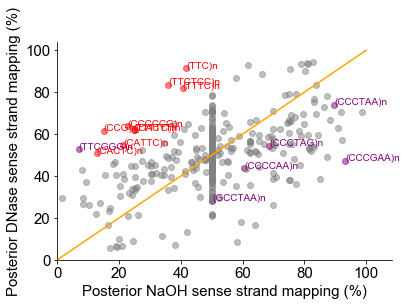

In [67]:
posterior_df['total'] =  posterior_df['DNase: antisense'] + posterior_df['DNase: sense']
posterior_df['x'] = posterior_df['DNase: eb_estimate'] * 100
posterior_df['y'] = posterior_df['NaOH: eb_estimate'] * 100

ax = plt.subplot(111)
for i, row in posterior_df.iterrows():
    if  ( row['y']/row['x'] > 2 and row['y'] > 50) or \
            (re.search(telo, row['gene_name']) and row['DNase: eb_estimate'] > row['NaOH: eb_estimate']):
        color = 'purple' if re.search(telo, row['gene_name']) else 'red'
        ax.text(row['x'],row['y'],
               row['gene_name'].replace('Simple_repeats:',''), 
                color=color,ha='left')
    else:
        color = 'grey'
        
    ax.scatter(row['x'], row['y'] , color = color, alpha=0.5)
ax.plot([0,100],[0,100], color = 'orange')
ax.set_ylabel('Posterior DNase sense strand mapping (%)')
ax.set_xlabel('Posterior NaOH sense strand mapping (%)')
ax.set_xlim(0,posterior_df['x'].max() * 1.1)
ax.set_ylim(0,posterior_df['y'].max() * 1.1)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
sns.despine()

In [72]:
posterior_df.assign(abs_delta_sense = lambda d: np.abs(d.delta_sense)).nlargest(20, 'abs_delta_sense')

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,...,NaOH: eb_estimate,NaOH: sense,log_bf,pval,qval,delta_sense,total,x,y,abs_delta_sense
216,Simple_repeats:(GAA)n,Simple_repeats,956.04006,682.0,0.582875,685.034278,0.582570,953.0,718.04006,7778.0,...,0.084485,715.0,2076.129192,0.000000e+00,0.000000e+00,0.498085,1635.0,58.256962,8.448450,0.498085
304,Simple_repeats:(TTC)n,Simple_repeats,685.04006,953.0,0.417125,956.034278,0.417434,682.0,7781.04006,715.0,...,0.915516,7778.0,2076.133592,1.000000e+00,1.518259e+02,-0.498082,1635.0,41.743390,91.551618,0.498082
234,Simple_repeats:(GGAGAA)n,Simple_repeats,100.04006,53.0,0.646667,56.034278,0.640977,97.0,178.04006,898.0,...,0.164993,175.0,170.344608,1.214324e-40,1.214324e-40,0.475984,150.0,64.097699,16.499332,0.475984
313,Simple_repeats:(TTCTCC)n,Simple_repeats,56.04006,97.0,0.353333,100.034278,0.359060,53.0,901.04006,175.0,...,0.835012,898.0,170.346797,1.000000e+00,1.608259e+02,-0.475952,150.0,35.906005,83.501204,0.475952
173,Simple_repeats:(CGG)n,Simple_repeats,826.04006,143.0,0.851967,146.034278,0.849770,823.0,964.04006,1540.0,...,0.384528,961.0,735.766233,9.210468e-198,9.210468e-198,0.465243,966.0,84.977046,38.452791,0.465243
147,Simple_repeats:(CCG)n,Simple_repeats,146.04006,823.0,0.148033,826.034278,0.150235,143.0,1543.04006,961.0,...,0.615474,1540.0,735.769290,1.000000e+00,1.588259e+02,-0.465239,966.0,15.023549,61.547439,0.465239
141,Simple_repeats:(CCCGAA)n,Simple_repeats,41.04006,0.0,1.000000,3.034278,0.931155,38.0,60.04006,64.0,...,0.472480,57.0,23.717666,1.228269e-11,1.695780e-11,0.458676,38.0,93.115545,47.247982,0.458676
311,Simple_repeats:(TTCGGG)n,Simple_repeats,3.04006,38.0,0.000000,41.034278,0.068976,0.0,67.04006,57.0,...,0.527566,64.0,23.720520,1.000000e+00,1.418259e+02,-0.458590,38.0,6.897574,52.756568,0.458590
148,Simple_repeats:(CCGAG)n,Simple_repeats,7.04006,0.0,1.000000,3.034278,0.698811,4.0,15.04006,39.0,...,0.263517,12.0,5.066489,1.868603e-03,4.890414e-03,0.435294,4.0,69.881117,26.351703,0.435294
217,Simple_repeats:(GAAA)n,Simple_repeats,1352.04006,922.0,0.594011,925.034278,0.593762,1349.0,3637.04006,16565.0,...,0.180006,3634.0,2370.277531,0.000000e+00,0.000000e+00,0.413756,2271.0,59.376193,18.000627,0.413756
